In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

%matplotlib inline

### https://www.baseball-reference.com/

Currently pulling all of 2017 to present day

tb_away --> Team Finder, Game, Batting --> Sort by 'Date of Game', Visiting team <br/>
tb_home --> Team Finder, Game, Batting --> Sort by 'Date of Game', Home team <br/>
https://www.baseball-reference.com/play-index/game_finder.cgi?class=team&type=b

tp_away --> Team Finder, Game, Pitching --> Sort by 'Date of Game', Visiting team <br/>
tp_home --> Team Finder, Game, Pitching --> Sort by 'Date of Game', Home team <br/>
https://www.baseball-reference.com/play-index/game_finder.cgi?class=team&type=p

pp_L --> Player Finder, Game, Pitching --> Sort by 'Date of Game', Left-Handed, STARTING PITCHERS ONLY: <br/>
pp_R --> Player Finder, Game, Pitching --> Sort by 'Date of Game', Right-Handed, STARTING PITCHERS ONLY: <br/>
https://www.baseball-reference.com/play-index/game_finder.cgi?type=p

To do:
- Possibly One-hot Encode Stadiums
- One-hot Encode Weather metrics
- Include ADI metrics

In [360]:
# Read in the data
tb_away = pd.read_csv('../data/team_batting_away_2018-05-14.csv')
tb_home = pd.read_csv('../data/team_batting_home_2018-05-14.csv')

tp_away = pd.read_csv('../data/team_pitching_away_2018-05-14.csv')
tp_home = pd.read_csv('../data/team_pitching_home_2018-05-14.csv')

pp_L = pd.read_csv('../data/player_pitching_L_2018-05-14.csv') 
pp_R = pd.read_csv('../data/player_pitching_R_2018-05-14.csv')

In [361]:
# Assure that shapes are as expected
print(tb_away.shape)
print(tb_home.shape)

print(tp_away.shape)
print(tp_home.shape)

print(pp_L.shape)
print(pp_R.shape)

(2909, 35)
(2909, 35)
(2909, 43)
(2909, 43)
(1573, 45)
(4245, 45)


In [362]:
# Make sure min/max dates match
print(tb_away['Date'].min())
print(tb_home['Date'].min())
print(tp_away['Date'].min())
print(tp_home['Date'].min())
print(pp_L['Date'].min())
print(pp_R['Date'].min())

print('\n')

print(tb_away['Date'].max())
print(tb_home['Date'].max())
print(tp_away['Date'].max())
print(tp_home['Date'].max())
print(pp_L['Date'].max())
print(pp_R['Date'].max())

2017-04-02
2017-04-02
2017-04-02
2017-04-02
2017-04-02
2017-04-02


2018-05-14
2018-05-14
2018-05-14
2018-05-14
2018-05-14
2018-05-14


In [363]:
# One-hot encode features not explicitly listed
tb_away['Home?'] = 0
tb_home['Home?'] = 1

tp_away['Home?'] = 0
tp_home['Home?'] = 1

pp_L['RH?'] = 0
pp_R['RH?'] = 1

In [364]:
# Collapse into combined dataframes
tb = pd.concat([tb_away, tb_home])
tp = pd.concat([tp_away, tp_home])
pp = pd.concat([pp_L, pp_R])

In [365]:
# Reset indices, and drop erroneous 'Rk'
tb.reset_index(drop=True, inplace=True)
tp.reset_index(drop=True, inplace=True)
pp.reset_index(drop=True, inplace=True)

tb.drop('Rk', axis=1, inplace=True)
tp.drop('Rk', axis=1, inplace=True)
pp.drop('Rk', axis=1, inplace=True)

In [366]:
# Define home stadiums, so we can define what stadium was played in
stadiums = {'BOS':'Fenway Park', 'CHC':'Wrigley Field', 'DET':'Comerica Park', 
            'LAA':'Angel Stadium', 'MIN':'Target Field', 'SDP':'Petco Park', 'SFG':'AT&T Park',
            'BAL':'Oriole Park', 'CLE':'Progressive Field', 'COL':'Coors Field', 
            'LAD':'Dodger Stadium', 'NYY': 'Yankee Stadium', 'PHI':'Citizens Bank Park',
            'PIT':'PNC Park', 'CHW':'Guaranteed Rate Field', 'CIN':'Great American Ball Park',
            'OAK':'O-A County Coliseum', 'TBR':'Tropicana Field', 'TEX':'Globe Life Park',
            'STL':'Busch Stadium', 'ATL':'SunTrust Park', 'KCR':'Kauffman Stadium', 
            'NYM':'Citi Field', 'WSN':'Nationals Park', 'MIA':'Marlins Park', 'MIL':'Miller Park',
            'ARI':'Chase Field', 'HOU':'Minute Maid Park', 'SEA':'Safeco Field', 
            'TOR':'Rogers Centre'
           }

In [367]:
# Assign stadium in 'tb', we will build up from there
stad_list = []
for i in tb.index:
    if tb.loc[i]['Home?'] == 1:
        stad_list.append(stadiums[tb.loc[i]['Tm']])
    else:
        stad_list.append(stadiums[tb.loc[i]['Opp']])
        
tb['Stad'] = stad_list

In [368]:
# Extract Doubleheader information from date, and make its own feature
tb['Game#'] = tb['Date'].apply(lambda x: int(x[-2]) if x[-1]==')' else 1)
tp['Game#'] = tp['Date'].apply(lambda x: int(x[-2]) if x[-1]==')' else 1)
pp['Game#'] = pp['Date'].apply(lambda x: int(x[-2]) if x[-1]==')' else 1)

In [369]:
# Remove Doubleheader information from date
tb['Date'] = tb['Date'].apply(lambda x: x[:10])
tp['Date'] = tp['Date'].apply(lambda x: x[:10])
pp['Date'] = pp['Date'].apply(lambda x: x[:10])

In [370]:
# Make Date a datetime type
tb['Date'] = pd.to_datetime(tb['Date'])
tp['Date'] = pd.to_datetime(tp['Date'])
pp['Date'] = pd.to_datetime(pp['Date'])

In [371]:
# Extract Win/Loss information from 'Rslt', and make its own feature
tb['Win/Loss'] = tb['Rslt'].apply(lambda x: 1 if x[0]=='W' else 0)
tp['Win/Loss'] = tp['Rslt'].apply(lambda x: 1 if x[0]=='W' else 0)
pp['Win/Loss'] = pp['Rslt'].apply(lambda x: 1 if x[0]=='W' else 0)

In [372]:
# Create Strikes-per-pitch, possible indicator of pitcher strength
tp['Str/Pit'] = tp['Str'] / tp['Pit']
pp['Str/Pit'] = pp['Str'] / pp['Pit']

In [373]:
# Create BattersFaced-per-inning-pitched, better pitches will face fewer batters
tp['BF/IP'] = tp['BF'] / tp['IP']
pp['BF/IP'] = pp['BF'] / pp['IP']

In [374]:
# Let's Drop the 2nd game of doubleheaders to simplify 
tb = tb[tb['Game#'].apply(lambda x: True if x==1 else False)]
tp = tp[tp['Game#'].apply(lambda x: True if x==1 else False)]
pp = pp[pp['Game#'].apply(lambda x: True if x==1 else False)]

In [375]:
print(tb.shape)
print(tp.shape)
print(pp.shape)

(5744, 38)
(5744, 47)
(5744, 49)


## Handling Null Values

In [376]:
# Assign 'WindDir' as 'none' wherever 'WindSpd' = 0
new_WindDir = []
for i in tb.index:
    if tb.loc[i]['WindSpd'] == 0:
        new_WindDir.append('none')
    else:
        new_WindDir.append(tb.loc[i]['WindDir'])
tb['WindDir'] = new_WindDir

#------------------------------

new_WindDir = []
for i in tp.index:
    if tp.loc[i]['WindSpd'] == 0:
        new_WindDir.append('none')
    else:
        new_WindDir.append(tp.loc[i]['WindDir'])
tp['WindDir'] = new_WindDir   

#-------------------------------

new_WindDir = []
for i in pp.index:
    if pp.loc[i]['WindSpd'] == 0:
        new_WindDir.append('none')
    else:
        new_WindDir.append(pp.loc[i]['WindDir'])
pp['WindDir'] = new_WindDir   

In [377]:
tb.isnull().sum()

Date             0
Tm               0
Opp              0
Rslt             0
PA               0
AB               0
R                0
H                0
2B               0
3B               0
HR               0
RBI              0
BB               0
IBB              0
SO               0
HBP              0
SH               0
SF               0
ROE              0
GDP              0
SB               0
CS               0
WPA              2
RE24             2
aLI              2
LOB              0
#                0
Attendance      30
GmLen            0
Temp             0
WindDir        220
WindSpd          0
Prec          4040
Sky            786
Home?            0
Stad             0
Game#            0
Win/Loss         0
dtype: int64

### Notes
- A lot of missing 'Precipitation' data. We might set these to 'none' until we can incorporate from another source
- Okay to drop balance of 'WindDir' nulls
- Not sure yet how to handle 'Sky'

In [378]:
tb['WindDir'].unique()

array(['tolf', 'tocf', 'rtol', 'ltor', 'torf', 'fromcf', 'fromrf',
       'fromlf', nan, 'none'], dtype=object)

In [379]:
tb['Prec'].unique()

array(['none', 'rain', 'drizzle', nan, 'snow'], dtype=object)

In [380]:
tb['Sky'].unique()

array(['cloudy', 'night', 'overcast', 'dome', 'sunny', nan], dtype=object)

#### May come back to find better handle of missing 'Prec' and 'Sky'

In [381]:
# Assign 'Prec' nulls as 'none'
new_Prec = []
for i in tb.index:
    if pd.isnull(tb.loc[i]['Prec']):
        new_Prec.append('none')
    else:
        new_Prec.append(tb.loc[i]['Prec'])
tb['Prec'] = new_Prec
        
#------------------------------
    
new_Prec = []
for i in tp.index:
    if pd.isnull(tp.loc[i]['Prec']):
        new_Prec.append('none')
    else:
        new_Prec.append(tp.loc[i]['Prec'])
tp['Prec'] = new_Prec

#------------------------------
        
new_Prec = []
for i in pp.index:
    if pd.isnull(pp.loc[i]['Prec']):
        new_Prec.append('none')
    else:
        new_Prec.append(pp.loc[i]['Prec'])
pp['Prec'] = new_Prec

In [382]:
tb.isnull().sum()

Date            0
Tm              0
Opp             0
Rslt            0
PA              0
AB              0
R               0
H               0
2B              0
3B              0
HR              0
RBI             0
BB              0
IBB             0
SO              0
HBP             0
SH              0
SF              0
ROE             0
GDP             0
SB              0
CS              0
WPA             2
RE24            2
aLI             2
LOB             0
#               0
Attendance     30
GmLen           0
Temp            0
WindDir       220
WindSpd         0
Prec            0
Sky           786
Home?           0
Stad            0
Game#           0
Win/Loss        0
dtype: int64

In [383]:
# We will drop 'Sky' nulls at Modeling step

## Sort DataFrames

In [384]:
# Sort team df's on Date, and then Team
tb.sort_values(['Date', 'Tm'], inplace=True)
tp.sort_values(['Date', 'Tm'], inplace=True)
pp.sort_values(['Date', 'Player'], inplace=True)

## Exploration

In [385]:
# Determin batting average within each stadiumtb[tb.columns[:]]
stad_bat_avg = {}
for stadium in stadiums.values():
    stad_tb = tb[tb['Stad']==stadium]
    
    num_hits = stad_tb['H'].sum()
    num_AB = stad_tb['AB'].sum()
    avg = num_hits / num_AB
    
    stad_bat_avg[stadium] = avg

<Container object of 30 artists>

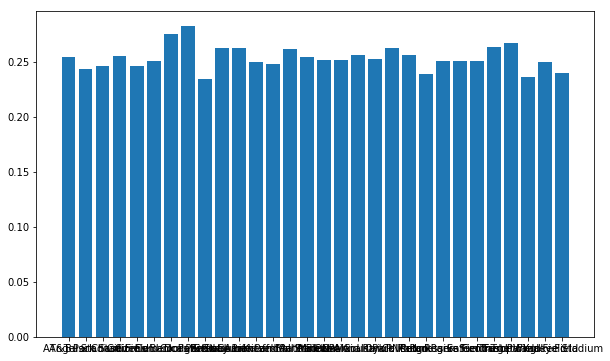

In [386]:
fig, ax = plt.subplots(figsize=(10,6))

plt.bar(stad_bat_avg.keys(), stad_bat_avg.values())

In [387]:
stad = []
avg = []
for i in stad_bat_avg:
    stad.append(i)
    avg.append(stad_bat_avg[i])
    df = pd.DataFrame(columns=['stad', 'avg'])
    df['stad'] = stad
    df['avg'] = avg
    df.sort_values('avg', inplace=True)

<Container object of 30 artists>

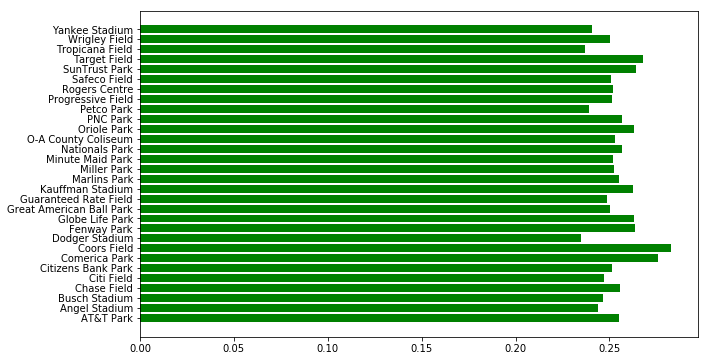

In [388]:
fig, ax = plt.subplots(figsize=(10,6))

ax.barh(df['stad'], df['avg'], align='center',
        color='green', ecolor='black')

In [389]:
tb[tb['Stad']=='Chase Field']['H'].sum() / tb[tb['Stad']=='Chase Field']['AB'].sum()

0.25551138417058183

In [390]:
tb[tb.columns[:]]

,Date,Tm,Opp,Rslt,PA,AB,R,H,2B,3B,...,GmLen,Temp,WindDir,WindSpd,Prec,Sky,Home?,Stad,Game#,Win/Loss
5184,2017-04-02,ARI,SFG,W 6-5,38,38,6,13,1,1,...,203,75,ltor,7,none,sunny,1,Chase Field,1,1
2275,2017-04-02,CHC,STL,L 3-4,36,34,3,8,1,0,...,213,63,rtol,8,none,NaN,0,Busch Stadium,1,0
2276,2017-04-02,NYY,TBR,L 3-7,39,36,3,9,1,0,...,201,72,none,0,none,dome,0,Tropicana Field,1,0
2277,2017-04-02,SFG,ARI,L 5-6,41,34,5,11,2,1,...,203,75,ltor,7,none,sunny,0,Chase Field,1,0
5185,2017-04-02,STL,CHC,W 4-3,44,35,4,11,2,0,...,213,63,rtol,8,none,NaN,1,Busch Stadium,1,1
5186,2017-04-02,TBR,NYY,W 7-3,40,36,7,13,2,0,...,201,72,none,0,none,dome,1,Tropicana Field,1,1
2279,2017-04-03,ATL,NYM,L 0-6,33,33,0,7,1,1,...,193,62,tolf,13,none,cloudy,0,Citi Field,1,0
5187,2017-04-03,BAL,TOR,W 3-2,41,39,3,9,4,0,...,221,65,rtol,14,none,NaN,1,Oriole Park,1,1
5188,2017-04-03,BOS,PIT,W 5-3,35,33,5,10,0,1,...,183,48,fromrf,13,none,cloudy,1,Fenway Park,1,1
5189,2017-04-03,CIN,PHI,L 3-4,37,32,3,9,1,1,...,184,68,fromrf,12,none,overcast,1,Great American Ball Park,1,0


In [391]:
tb[tb['Home?']==1]['H'].sum() / tb[tb['Home?']==1]['AB'].sum()

0.25896975642336834

In [392]:
tb[tb['Home?']==0]['H'].sum() / tb[tb['Home?']==0]['AB'].sum()

0.24936869316990887

In [393]:
# We'll come back to this

# Begin Rolling Stats

In [394]:
tb_window = ['PA', 'R', 'H', '2B', '3B', 'HR', 'RBI', # batting strength
             'SO', 'GDP', 'LOB', # batting weakness
             'SB', # running strength
             'CS', # running weakness
             'Win/Loss', # overall team winningness
             'WPA', 'RE24', 'aLI' # BR Measures
            ]

tp_window = ['BF', 'R', 'H', '2B', '3B', 'ER', 'HR', 'Pit',# opponent pitching weakness
             'SO', 'WP', 'Str', 'GDP', 'Str/Pit', 'Win/Loss', # opponent pitching strength
             'WPA', 'RE24', 'aLI', # BR Measures
             '#' # May want to track average number of pitchers used
            ]

pp_window = ['IP', # May want to track deepness of starter
              'DFS(DK)', 'DFS(FD)', # May be rather informative
              'R', 'H', '2B', '3B', 'ER', 'HR', 'BB', 'BF/IP', 'WP', # opponent starting p weakness
              'SO', 'Str/Pit', 'GDP', # opponent starting p strength
              'GSc', 'WPA', 'RE24', 'aLI' # BR Measures
             ]

In [395]:
### DO I NEED TO SET DATE TO THE INDEX BEFORE ROLLING???

## Rolling Team Batting

In [396]:
teams = tb['Tm'].unique()

In [397]:
rolling_cols = []
for i in tb_window:
    rolling_cols.append('ewm03_'+i+'_tmbat')
for i in tb_window:
    rolling_cols.append('ewm15_'+i+'_tmbat')
for j in tb_window:
    rolling_cols.append('rm81_'+j+'_tmbat')
    
rolling_cols.append('Tm')
rolling_cols.append('Date')

In [398]:
rolling_cols

['ewm03_PA_tmbat',
 'ewm03_R_tmbat',
 'ewm03_H_tmbat',
 'ewm03_2B_tmbat',
 'ewm03_3B_tmbat',
 'ewm03_HR_tmbat',
 'ewm03_RBI_tmbat',
 'ewm03_SO_tmbat',
 'ewm03_GDP_tmbat',
 'ewm03_LOB_tmbat',
 'ewm03_SB_tmbat',
 'ewm03_CS_tmbat',
 'ewm03_Win/Loss_tmbat',
 'ewm03_WPA_tmbat',
 'ewm03_RE24_tmbat',
 'ewm03_aLI_tmbat',
 'ewm15_PA_tmbat',
 'ewm15_R_tmbat',
 'ewm15_H_tmbat',
 'ewm15_2B_tmbat',
 'ewm15_3B_tmbat',
 'ewm15_HR_tmbat',
 'ewm15_RBI_tmbat',
 'ewm15_SO_tmbat',
 'ewm15_GDP_tmbat',
 'ewm15_LOB_tmbat',
 'ewm15_SB_tmbat',
 'ewm15_CS_tmbat',
 'ewm15_Win/Loss_tmbat',
 'ewm15_WPA_tmbat',
 'ewm15_RE24_tmbat',
 'ewm15_aLI_tmbat',
 'rm81_PA_tmbat',
 'rm81_R_tmbat',
 'rm81_H_tmbat',
 'rm81_2B_tmbat',
 'rm81_3B_tmbat',
 'rm81_HR_tmbat',
 'rm81_RBI_tmbat',
 'rm81_SO_tmbat',
 'rm81_GDP_tmbat',
 'rm81_LOB_tmbat',
 'rm81_SB_tmbat',
 'rm81_CS_tmbat',
 'rm81_Win/Loss_tmbat',
 'rm81_WPA_tmbat',
 'rm81_RE24_tmbat',
 'rm81_aLI_tmbat',
 'Tm',
 'Date']

In [399]:
tb_rolling = pd.DataFrame(columns = rolling_cols)

for team in teams:
    tb_team = tb[tb['Tm']==team]
    
    # Try to capture shorter term strength/weakness
    ewm03 = tb_team[tb_window].ewm(span=3, min_periods=1).mean().shift()
    ewm15 = tb_team[tb_window].ewm(span=15, min_periods=1).mean().shift()
    # 81 games covers half a season, captures typical strength/weakness
    rm81 = tb_team[tb_window].rolling(window=81, min_periods=1).mean().shift()
    
    this_df = pd.concat([ewm03, ewm15, rm81], axis=1)

    this_df['Tm'] = team
    this_df['Date'] = tb_team['Date']
    this_df.columns = rolling_cols
    
    tb_rolling = pd.concat([tb_rolling, this_df])

In [400]:
tb_rolling.set_index(['Date', 'Tm'], drop=False, inplace=True)
tb.set_index(['Date', 'Tm'], drop=False, inplace=True)

In [401]:
print(tb.shape)
print(tb_rolling.shape)

(5744, 38)
(5744, 50)


In [402]:
master = tb.merge(tb_rolling, how='left', on=['Date', 'Tm'])

In [403]:
master.shape

(5744, 86)

In [404]:
master[master['Tm']=='ARI'][['Date', 'H', 'ewm03_H_tmbat']]

,Date,H,ewm03_H_tmbat
0,2017-04-02,13,NaN
28,2017-04-04,7,13.000000
46,2017-04-05,12,9.000000
72,2017-04-06,11,10.714286
96,2017-04-07,11,10.866667
126,2017-04-08,15,10.935484
156,2017-04-09,8,13.000000
186,2017-04-10,4,10.480315
206,2017-04-11,9,7.227451
230,2017-04-12,8,8.115460


## Rolling Opposing Pitching Staff, Team Level

In [405]:
rolling_cols = []
for i in tp_window:
    rolling_cols.append('ewm03_'+i+'_opppit')
for i in tp_window:
    rolling_cols.append('ewm15_'+i+'_opppit')
for j in tp_window:
    rolling_cols.append('rm81_'+j+'_opppit')
    
rolling_cols.append('Tm')
rolling_cols.append('Date')

In [406]:
rolling_cols

['ewm03_BF_opppit',
 'ewm03_R_opppit',
 'ewm03_H_opppit',
 'ewm03_2B_opppit',
 'ewm03_3B_opppit',
 'ewm03_ER_opppit',
 'ewm03_HR_opppit',
 'ewm03_Pit_opppit',
 'ewm03_SO_opppit',
 'ewm03_WP_opppit',
 'ewm03_Str_opppit',
 'ewm03_GDP_opppit',
 'ewm03_Str/Pit_opppit',
 'ewm03_Win/Loss_opppit',
 'ewm03_WPA_opppit',
 'ewm03_RE24_opppit',
 'ewm03_aLI_opppit',
 'ewm03_#_opppit',
 'ewm15_BF_opppit',
 'ewm15_R_opppit',
 'ewm15_H_opppit',
 'ewm15_2B_opppit',
 'ewm15_3B_opppit',
 'ewm15_ER_opppit',
 'ewm15_HR_opppit',
 'ewm15_Pit_opppit',
 'ewm15_SO_opppit',
 'ewm15_WP_opppit',
 'ewm15_Str_opppit',
 'ewm15_GDP_opppit',
 'ewm15_Str/Pit_opppit',
 'ewm15_Win/Loss_opppit',
 'ewm15_WPA_opppit',
 'ewm15_RE24_opppit',
 'ewm15_aLI_opppit',
 'ewm15_#_opppit',
 'rm81_BF_opppit',
 'rm81_R_opppit',
 'rm81_H_opppit',
 'rm81_2B_opppit',
 'rm81_3B_opppit',
 'rm81_ER_opppit',
 'rm81_HR_opppit',
 'rm81_Pit_opppit',
 'rm81_SO_opppit',
 'rm81_WP_opppit',
 'rm81_Str_opppit',
 'rm81_GDP_opppit',
 'rm81_Str/Pit_opppit

In [407]:
tp_rolling = pd.DataFrame(columns = rolling_cols)

for team in teams:
    tp_team = tp[tp['Tm']==team]
    
    ewm03 = tp_team[tp_window].ewm(span=3, min_periods=1).mean().shift()
    ewm15 = tp_team[tp_window].ewm(span=15, min_periods=1).mean().shift()
    rm81 = tp_team[tp_window].rolling(window=81, min_periods=1).mean().shift()
    
    this_df = pd.concat([ewm03, ewm15, rm81], axis=1)

    this_df['Tm'] = team
    this_df['Date'] = tp_team['Date']
    this_df.columns = rolling_cols
    
    tp_rolling = pd.concat([tp_rolling, this_df])

In [408]:
tp_rolling.set_index(['Date', 'Tm'], drop=False, inplace=True)

In [409]:
print(master.shape)
print(tp_rolling.shape)

(5744, 86)
(5744, 56)


In [410]:
master = master.merge(tp_rolling, how='left', left_on=['Date', 'Opp'], right_on=['Date', 'Tm'])

In [411]:
master.shape

(5744, 141)

In [412]:
master[master['Opp']=='ARI'][['Date', 'SO', 'rm81_SO_opppit']]

,Date,SO,rm81_SO_opppit
3,2017-04-02,7,NaN
42,2017-04-04,12,7.000000
67,2017-04-05,11,9.500000
91,2017-04-06,7,10.000000
103,2017-04-07,8,9.250000
133,2017-04-08,7,9.000000
163,2017-04-09,5,8.666667
202,2017-04-10,5,8.142857
225,2017-04-11,11,7.750000
254,2017-04-12,7,8.111111


## Rolling Opposing Starting Pitcher

In [413]:
rolling_cols = []
for i in pp_window:
    rolling_cols.append('ewm03_'+i+'_plpit')
for i in pp_window:
    rolling_cols.append('ewm15_'+i+'_plpit')
for j in pp_window:
    rolling_cols.append('rm81_'+j+'_plpit')

rolling_cols.append('Player')
rolling_cols.append('Tm')
rolling_cols.append('Date')

In [414]:
rolling_cols

['ewm03_IP_plpit',
 'ewm03_DFS(DK)_plpit',
 'ewm03_DFS(FD)_plpit',
 'ewm03_R_plpit',
 'ewm03_H_plpit',
 'ewm03_2B_plpit',
 'ewm03_3B_plpit',
 'ewm03_ER_plpit',
 'ewm03_HR_plpit',
 'ewm03_BB_plpit',
 'ewm03_BF/IP_plpit',
 'ewm03_WP_plpit',
 'ewm03_SO_plpit',
 'ewm03_Str/Pit_plpit',
 'ewm03_GDP_plpit',
 'ewm03_GSc_plpit',
 'ewm03_WPA_plpit',
 'ewm03_RE24_plpit',
 'ewm03_aLI_plpit',
 'ewm15_IP_plpit',
 'ewm15_DFS(DK)_plpit',
 'ewm15_DFS(FD)_plpit',
 'ewm15_R_plpit',
 'ewm15_H_plpit',
 'ewm15_2B_plpit',
 'ewm15_3B_plpit',
 'ewm15_ER_plpit',
 'ewm15_HR_plpit',
 'ewm15_BB_plpit',
 'ewm15_BF/IP_plpit',
 'ewm15_WP_plpit',
 'ewm15_SO_plpit',
 'ewm15_Str/Pit_plpit',
 'ewm15_GDP_plpit',
 'ewm15_GSc_plpit',
 'ewm15_WPA_plpit',
 'ewm15_RE24_plpit',
 'ewm15_aLI_plpit',
 'rm81_IP_plpit',
 'rm81_DFS(DK)_plpit',
 'rm81_DFS(FD)_plpit',
 'rm81_R_plpit',
 'rm81_H_plpit',
 'rm81_2B_plpit',
 'rm81_3B_plpit',
 'rm81_ER_plpit',
 'rm81_HR_plpit',
 'rm81_BB_plpit',
 'rm81_BF/IP_plpit',
 'rm81_WP_plpit',
 'rm81_

In [415]:
pitchers = pp['Player'].unique()

In [416]:
pp[pp['Player']==pitchers[0]]

,Player,Date,Tm,Opp,Rslt,AppDec,IP,H,R,ER,...,Temp,WindDir,WindSpd,Prec,Sky,RH?,Game#,Win/Loss,Str/Pit,BF/IP
3367,Carlos Martinez\martica04,2017-04-02,STL,CHC,W 4-3,GS-8,7.1,6,0,0,...,63,rtol,8,none,NaN,1,1,1,0.647619,3.802817
3489,Carlos Martinez\martica04,2017-04-09,STL,CIN,L 0-8,GS-6 L,5.0,6,6,5,...,78,tolf,17,none,cloudy,1,1,0,0.662921,4.600000
3601,Carlos Martinez\martica04,2017-04-15,STL,NYY,L 2-3,GS-6 L,5.1,4,3,2,...,58,rtol,10,none,NaN,1,1,0,0.601695,5.882353
3691,Carlos Martinez\martica04,2017-04-20,STL,MIL,L 5-7,GS-5 L,5.0,7,5,5,...,65,none,0,none,dome,1,1,0,0.637500,4.800000
3828,Carlos Martinez\martica04,2017-04-27,STL,TOR,W 8-4,GS-6,6.0,5,3,3,...,52,torf,8,none,overcast,1,1,1,0.680412,4.500000
3924,Carlos Martinez\martica04,2017-05-02,STL,MIL,W 2-1,GS-8 W,7.1,4,1,0,...,64,torf,8,none,sunny,1,1,1,0.685714,3.943662
4045,Carlos Martinez\martica04,2017-05-08,STL,MIA,W 9-4,GS-6 W,6.0,5,3,3,...,80,fromlf,11,none,sunny,1,1,1,0.673684,3.833333
4142,Carlos Martinez\martica04,2017-05-13,STL,CHC,W 5-3,GS-7 W,6.2,5,3,3,...,80,rtol,10,none,sunny,1,1,1,0.626263,4.677419
4285,Carlos Martinez\martica04,2017-05-20,STL,SFG,L 1-3,GS-9,9.0,2,0,0,...,79,tolf,5,none,cloudy,1,1,0,0.698925,3.222222
4414,Carlos Martinez\martica04,2017-05-26,STL,COL,L 0-10,GS-8 L,7.1,6,3,3,...,70,rtol,8,none,sunny,1,1,0,0.687500,3.943662


In [417]:
pp_rolling = pd.DataFrame(columns = rolling_cols)

for pitcher in pitchers:
    pp_pitcher = pp[pp['Player']==pitcher]
    
    ewm03 = pp_pitcher[pp_window].ewm(span=3, min_periods=1).mean().shift()
    ewm15 = pp_pitcher[pp_window].ewm(span=15, min_periods=1).mean().shift()
    rm81 = pp_pitcher[pp_window].rolling(window=81, min_periods=1).mean().shift()
    
    this_df = pd.concat([ewm03, ewm15, rm81], axis=1)

    this_df['Player'] = pitcher
    this_df['Tm'] = pp_pitcher['Tm']
    this_df['Date'] = pp_pitcher['Date']
    this_df.columns = rolling_cols
    
    pp_rolling = pd.concat([pp_rolling, this_df])

In [418]:
pp_rolling.head()

,ewm03_IP_plpit,ewm03_DFS(DK)_plpit,ewm03_DFS(FD)_plpit,ewm03_R_plpit,ewm03_H_plpit,ewm03_2B_plpit,ewm03_3B_plpit,ewm03_ER_plpit,ewm03_HR_plpit,ewm03_BB_plpit,...,rm81_SO_plpit,rm81_Str/Pit_plpit,rm81_GDP_plpit,rm81_GSc_plpit,rm81_WPA_plpit,rm81_RE24_plpit,rm81_aLI_plpit,Player,Tm,Date
3367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carlos Martinez\martica04,STL,2017-04-02
3489,7.100000,32.900000,52.000000,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,10.00,0.647619,1.000000,76.000000,0.373000,3.13500,1.228000,Carlos Martinez\martica04,STL,2017-04-09
3601,5.700000,12.200000,23.333333,4.000000,6.000000,1.000000,0.666667,3.333333,0.666667,0.666667,...,6.50,0.655270,1.000000,55.500000,0.106500,0.16050,1.082500,Carlos Martinez\martica04,STL,2017-04-15
3691,5.357143,18.257143,34.571429,3.428571,4.857143,1.000000,0.285714,2.571429,0.285714,4.857143,...,8.00,0.637412,0.666667,54.666667,0.062667,0.01700,1.123667,Carlos Martinez\martica04,STL,2017-04-20
3828,5.166667,13.773333,27.333333,4.266667,6.000000,0.466667,0.133333,3.866667,1.200000,3.333333,...,7.75,0.637434,0.500000,50.500000,-0.027750,-0.58425,1.071000,Carlos Martinez\martica04,STL,2017-04-27


In [419]:
pp_rolling.set_index(['Date', 'Tm'], drop=False, inplace=True)

In [420]:
print(master.shape)
print(pp_rolling.shape)

(5744, 141)
(5744, 60)


In [421]:
master = master.merge(pp_rolling, how='left', left_on=['Date', 'Opp'], right_on=['Date', 'Tm'])

In [422]:
master.shape

(5744, 200)

In [423]:
master[master.columns[28:]].head()

,GmLen,Temp,WindDir,WindSpd,Prec,Sky,Home?,Stad,Game#,Win/Loss,...,rm81_WP_plpit,rm81_SO_plpit,rm81_Str/Pit_plpit,rm81_GDP_plpit,rm81_GSc_plpit,rm81_WPA_plpit,rm81_RE24_plpit,rm81_aLI_plpit,Player,Tm
0,203,75,ltor,7,none,sunny,1,Chase Field,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Madison Bumgarner\bumgama01,SFG
1,213,63,rtol,8,none,NaN,0,Busch Stadium,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carlos Martinez\martica04,STL
2,201,72,none,0,none,dome,0,Tropicana Field,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chris Archer\archech01,TBR
3,203,75,ltor,7,none,sunny,0,Chase Field,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zack Greinke\greinza01,ARI
4,213,63,rtol,8,none,NaN,1,Busch Stadium,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jon Lester\lestejo01,CHC


In [426]:
from sklearn.feature_extraction.text import CountVectorizer

## One-Hot Encode Weather Metrics 'WindDir', 'Prec', 'Sky'

In [431]:
# Drop 'Sky' for now
master.drop('Sky', axis=1, inplace=True)

In [432]:
# Drop remaining nulls so that CountVectorizer will work
master.dropna(inplace=True)

In [433]:
cv = CountVectorizer()

In [435]:
cv.fit_transform(master['Prec'])

<5167x4 sparse matrix of type '<class 'numpy.int64'>'
	with 5167 stored elements in Compressed Sparse Row format>

# Modeling

In [357]:
list(master.isnull().sum())

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 30,
 0,
 0,
 220,
 0,
 0,
 786,
 0,
 0,
 0,
 0,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 0,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,
 343,

In [358]:
master.dropna(inplace=True)

In [359]:
list(master.columns)

['Date',
 'Tm_x',
 'Opp',
 'Rslt',
 'PA',
 'AB',
 'R',
 'H',
 '2B',
 '3B',
 'HR',
 'RBI',
 'BB',
 'IBB',
 'SO',
 'HBP',
 'SH',
 'SF',
 'ROE',
 'GDP',
 'SB',
 'CS',
 'WPA',
 'RE24',
 'aLI',
 'LOB',
 '#',
 'Attendance',
 'GmLen',
 'Temp',
 'WindDir',
 'WindSpd',
 'Prec',
 'Sky',
 'Home?',
 'Stad',
 'Game#',
 'Win/Loss',
 'ewm03_PA_tmbat',
 'ewm03_R_tmbat',
 'ewm03_H_tmbat',
 'ewm03_2B_tmbat',
 'ewm03_3B_tmbat',
 'ewm03_HR_tmbat',
 'ewm03_RBI_tmbat',
 'ewm03_SO_tmbat',
 'ewm03_GDP_tmbat',
 'ewm03_LOB_tmbat',
 'ewm03_SB_tmbat',
 'ewm03_CS_tmbat',
 'ewm03_Win/Loss_tmbat',
 'ewm03_WPA_tmbat',
 'ewm03_RE24_tmbat',
 'ewm03_aLI_tmbat',
 'ewm15_PA_tmbat',
 'ewm15_R_tmbat',
 'ewm15_H_tmbat',
 'ewm15_2B_tmbat',
 'ewm15_3B_tmbat',
 'ewm15_HR_tmbat',
 'ewm15_RBI_tmbat',
 'ewm15_SO_tmbat',
 'ewm15_GDP_tmbat',
 'ewm15_LOB_tmbat',
 'ewm15_SB_tmbat',
 'ewm15_CS_tmbat',
 'ewm15_Win/Loss_tmbat',
 'ewm15_WPA_tmbat',
 'ewm15_RE24_tmbat',
 'ewm15_aLI_tmbat',
 'rm81_PA_tmbat',
 'rm81_R_tmbat',
 'rm81_H_tmbat'

In [447]:
drop_cols = ['Date', 'Tm_x', 'Opp', 'Rslt', 'PA', 'AB', 'H', '2B', '3B', 'HR',
            'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'ROE', 'GDP', 'SB', 'CS', 'WPA',
            'RE24', 'aLI', 'LOB', '#', 'Attendance', 'GmLen', 'Game#', 'Win/Loss', 'Tm_y',
            'Player', 'Tm',
            'WindDir', 'Prec', 'Stad']

In [448]:
model_df = master.drop(drop_cols, axis=1)

In [141]:
model_df.corr()

,R,ewm10_PA_tmbat,ewm10_R_tmbat,ewm10_H_tmbat,ewm10_2B_tmbat,ewm10_3B_tmbat,ewm10_HR_tmbat,ewm10_RBI_tmbat,ewm10_SO_tmbat,ewm10_GDP_tmbat,...,rm10_BB_plpit,rm10_BF/IP_plpit,rm10_WP_plpit,rm10_SO_plpit,rm10_Str/Pit_plpit,rm10_GDP_plpit,rm10_GSc_plpit,rm10_WPA_plpit,rm10_RE24_plpit,rm10_aLI_plpit
R,1.000000,0.000700,0.044930,0.026597,0.073982,0.005963,0.036567,0.039719,-0.078117,-0.033505,...,0.030610,0.044863,0.004835,-0.127981,-0.045282,-0.025392,-0.074043,-0.034298,-0.036686,-0.008360
ewm10_PA_tmbat,0.000700,1.000000,0.584769,0.691994,0.457010,0.104456,0.212001,0.582837,-0.046146,0.034405,...,0.000213,0.015775,0.018836,-0.024544,-0.050197,0.009022,0.003369,0.022939,0.027904,0.072290
ewm10_R_tmbat,0.044930,0.584769,1.000000,0.744240,0.566912,0.208445,0.586788,0.991465,-0.235077,-0.075006,...,0.019167,0.019832,0.049343,-0.018730,-0.035616,0.003199,-0.003906,0.014157,0.010570,0.021871
ewm10_H_tmbat,0.026597,0.691994,0.744240,1.000000,0.582201,0.155336,0.427592,0.738193,-0.311716,0.112488,...,0.004317,0.026836,0.022383,-0.007883,-0.009784,0.027007,0.022753,0.036855,0.033316,0.025629
ewm10_2B_tmbat,0.073982,0.457010,0.566912,0.582201,1.000000,0.131199,0.186431,0.567936,-0.173722,-0.123763,...,0.035481,0.001408,0.055938,0.010071,-0.032115,0.035715,0.012877,0.014994,0.018649,0.011641
ewm10_3B_tmbat,0.005963,0.104456,0.208445,0.155336,0.131199,1.000000,-0.073212,0.210430,-0.071032,-0.093848,...,-0.019116,0.007892,-0.018376,-0.031143,0.026833,-0.026979,-0.020731,-0.011626,-0.013701,-0.001640
ewm10_HR_tmbat,0.036567,0.212001,0.586788,0.427592,0.186431,-0.073212,1.000000,0.595375,-0.060363,-0.049306,...,0.026360,0.072557,0.000504,-0.029707,-0.052300,0.042198,-0.051316,-0.032220,-0.047474,0.020884
ewm10_RBI_tmbat,0.039719,0.582837,0.991465,0.738193,0.567936,0.210430,0.595375,1.000000,-0.228618,-0.079468,...,0.021324,0.020659,0.042226,-0.024403,-0.034255,0.009249,-0.003590,0.011825,0.009821,0.017354
ewm10_SO_tmbat,-0.078117,-0.046146,-0.235077,-0.311716,-0.173722,-0.071032,-0.060363,-0.228618,1.000000,-0.080027,...,-0.036211,-0.015075,-0.015323,0.021727,0.034052,-0.018189,0.005515,0.000855,0.006191,0.028841
ewm10_GDP_tmbat,-0.033505,0.034405,-0.075006,0.112488,-0.123763,-0.093848,-0.049306,-0.079468,-0.080027,1.000000,...,-0.018391,-0.040878,-0.015713,0.082228,-0.010170,0.019925,0.056319,0.040460,0.043169,-0.007715


In [449]:
X = model_df.drop('R', axis=1)
y = model_df['R']

In [450]:
print(X.shape)
print(y.shape)

(5167, 162)
(5167,)


In [451]:
X.head()

,Temp,WindSpd,Home?,ewm03_PA_tmbat,ewm03_R_tmbat,ewm03_H_tmbat,ewm03_2B_tmbat,ewm03_3B_tmbat,ewm03_HR_tmbat,ewm03_RBI_tmbat,...,rm81_BB_plpit,rm81_BF/IP_plpit,rm81_WP_plpit,rm81_SO_plpit,rm81_Str/Pit_plpit,rm81_GDP_plpit,rm81_GSc_plpit,rm81_WPA_plpit,rm81_RE24_plpit,rm81_aLI_plpit
128,59,16,1,33.000000,4.714286,6.714286,1.142857,0.0,1.857143,4.714286,...,2.0,8.181818,0.0,3.0,0.611940,0.0,15.0,-0.467,-5.871,0.816
133,86,10,0,38.533333,5.066667,7.266667,1.266667,0.0,1.333333,5.000000,...,2.0,4.200000,0.0,4.0,0.597826,0.0,53.0,0.045,0.846,0.949
134,75,11,1,33.516129,2.290323,6.129032,1.645161,0.0,1.064516,2.258065,...,0.0,3.428571,1.0,8.0,0.726190,0.0,75.0,0.077,1.508,0.440
136,77,16,1,36.258065,1.903226,6.838710,1.032258,0.0,0.838710,1.903226,...,3.0,4.000000,0.0,8.0,0.620000,0.0,67.0,0.230,2.134,0.968
137,77,16,0,39.200000,3.666667,8.466667,1.333333,0.0,1.133333,2.866667,...,2.0,3.571429,0.0,4.0,0.623529,1.0,75.0,0.382,3.359,1.147


In [452]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [453]:
ss = StandardScaler()
X = ss.fit_transform(X)

In [454]:
X

array([[-1.15713376,  1.58411434,  1.00058078, ..., -4.75608032,
        -5.85571735, -1.45540863],
       [ 1.26122935,  0.3959711 , -0.99941956, ...,  0.34162496,
         0.72608659, -0.13493501],
       [ 0.2759703 ,  0.59399497,  1.00058078, ...,  0.66023154,
         1.37476222, -5.1884769 ],
       ...,
       [-0.70928874,  0.99004272,  1.00058078, ..., -0.24059064,
         0.03037707, -0.90178363],
       [-0.17187472,  0.3959711 , -0.99941956, ..., -0.09702803,
        -0.28850145,  0.09738892],
       [-1.33627177,  0.99004272,  1.00058078, ..., -0.58865431,
        -0.37354343,  0.19615465]])

In [455]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [456]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4133, 162)
(4133,)
(1034, 162)
(1034,)


In [457]:
lr = LinearRegression()
lr.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [458]:
lr.score(X_train, y_train)

0.06078624569746138

In [459]:
y_train - lr.predict(X_train)

3377    5.393203
4867   -2.946127
4349    4.601318
4364   -1.737753
5611   -0.788081
4291   -1.096065
773    -3.458018
1906   -3.479683
5488    5.666746
1195   -0.743179
4640    0.223483
1684   -1.566106
5420   -3.379699
4754   -1.361176
5631    1.363008
5430   -2.708421
5044    0.566226
1447   -2.519871
170    -2.403772
4910   -1.656038
1713    5.252933
415    -2.402450
329     0.393599
3323    1.447960
1388   -4.373621
1976    1.155435
2926   -3.278359
886     5.937223
1242    0.600295
1545    2.512764
          ...   
1547   -0.563889
1626   -1.924660
1676   -1.479297
666     1.354186
5438   -2.283618
446    -0.345243
5507    1.133337
5300    3.733656
718     0.522577
5061   -1.972179
4027    2.788214
2415   -0.313355
1064   -0.875639
1082    0.078381
2988    2.096497
2593   -0.204035
4259   -1.749925
1835   -1.737021
2807   -0.260838
4952   -1.995307
770     1.942696
647     2.801071
672    -0.900847
991    -1.308423
3095   -0.604850
4150   -3.295729
2960    6.667939
1561   -2.0120

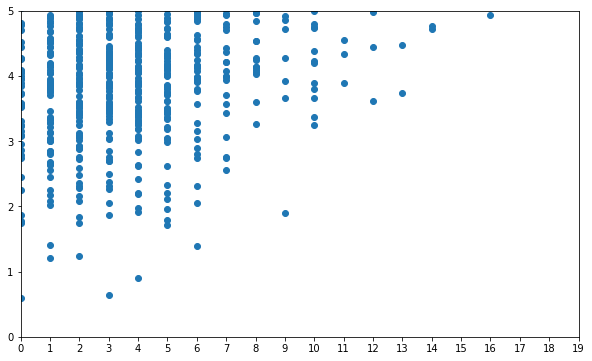

In [193]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_train, lr.predict(X_train))
plt.xlim(0,5)
plt.ylim(0,5)
plt.xticks(range(0,20));

In [181]:
y_train.describe()

count    783.000000
mean       4.577267
std        3.290511
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       20.000000
Name: R, dtype: float64

In [188]:
preds = lr.predict(X_train)
pd.Series(preds).describe()

count    783.000000
mean       4.577267
std        1.317801
min        0.592127
25%        3.710036
50%        4.529145
75%        5.469469
max        8.904258
dtype: float64

## Modeling Win/Loss

In [194]:
drop_cols = ['Rk', 'Date', 'Tm_x', 'Opp', 'Rslt', 'PA', 'AB', 'H', '2B', '3B', 'HR', 'R',
            'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'ROE', 'GDP', 'SB', 'CS', 'WPA',
            'RE24', 'aLI', 'LOB', '#', 'Attendance', 'GmLen', 'Game#', 'Tm_y',
            'Player', 'Tm']

In [195]:
model_df = master.drop(drop_cols, axis=1)

In [196]:
X = model_df.drop('Win/Loss', axis=1)
y = model_df['Win/Loss']

- Note: I want Home/Away and ADI/weather info

## tb: Team Batting
- PA: Plate Appearances
- AB: At Bats
- R: Runs
- H: Hits
- BB: Bases on Balls
- IBB: Intentional Bases on Balls 
- SO: Strikeouts
- HBP: Hit-by-pitch
- SH: Sacrifice Hits
- SF: Sacrifice Flies
- ROE: Reached on Error
- GDB: Double Plays Grounded Into
- SB: Stolen Bases
- CS: Caught Stealing
- WPA: Win Probability Added for Offensive Player (BR measure)
- RE24: Base-out Runs Added (BR measure)
- aLI: Average Leverage Index (BR measure)
- LOB: Runners Left on Base
- #: Number of Players Used in Game
- GmLen: Game Length (minutes)

## tp: Team Pitching
- ER: Earned Runs Allowed
- UER: Unearned Runs Allowed
- Pit: Number of total pitches
- Str: Number of total strikes
- IR: Number of inherited runners
- IS: Inherited Score
- BF: Batters Faced
- SB: Stolen Bases
- CS: Caught Stealing
- PO: Pickoffs
- BK: Balks
- ERA: Earned Run Average
- WPA: Win Probability added by Pitcher (BR measure)
- RE24: Base-Out Runs Saved (BR measure)
- #: Number of pitchers used in the game

## pp: Player Pitching
- AppDec: Indicates starting and ending of pitcher
- GSc: Game Score (BR Measure)
- WP: Wild Pitches